### This notebook is used for running inferences on the AOI data
Before running this notebook make sure the model and the data for inference are prepared. 

In [ ]:
import os
import numpy as np
import rasterio
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from rasterio.merge import merge
from rasterio.plot import show

In [ ]:
# choose the city and the year to run the inference on
city_name = "Cologne"

cities_path = "root/path"

image_directory = os.path.join(cities_path, city_name, "tiles")

image_len = len(os.listdir(image_directory))
print("Tiles:", len(os.listdir(image_directory)))

**Defining the dataset**

In [ ]:
# setting hyperparameters. make sure the hyperparameters are the same as used for training the model.
hparams = {
    'in_channels': 12,
    'out_channels': 1,
    'features': [64, 128, 256, 512],
    'learning_rate': 1e-4,
    'batch_size': 1
}

BATCH_SIZE = hparams["batch_size"]
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = hparams["in_channels"]

# filename sorting function
def extract_last_two_numbers(filename):
    parts = filename.split('_')
    second_last = int(parts[-2])
    last = int(parts[-1].split('.')[0]) 
    return (second_last, last)


class InferenceDataset(Dataset):
    def __init__(self, image_filenames, img_size):
        self.image_filenames = image_filenames
        self.img_size = img_size

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = self.image_filenames[idx]
        with rasterio.open(img_path) as src:
            img = src.read(
                out_shape=(
                    src.count,
                    self.img_size[0],
                    self.img_size[1]
                ),
                resampling=rasterio.enums.Resampling.bilinear
            )
            img = np.transpose(img, (1, 2, 0))

        img = np.transpose(img, (2, 0, 1))  

        return torch.tensor(img, dtype=torch.float32)


# image directories
image_dirs = [image_directory]


image_filenames = []

for image_dir in image_dirs:
    image_files = sorted(os.listdir(image_dir), key=extract_last_two_numbers)
    image_filenames.extend([os.path.join(image_dir, img) for img in image_files])

image_filenames = [i for i in image_filenames]

test_dataset = InferenceDataset(image_filenames, img_size=(IMG_HEIGHT, IMG_WIDTH))

# instantiating the dataloader
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Img shape: (128, 128, 12)


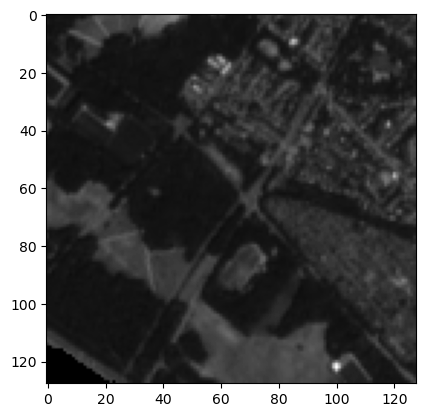

Img shape: (128, 128, 12)


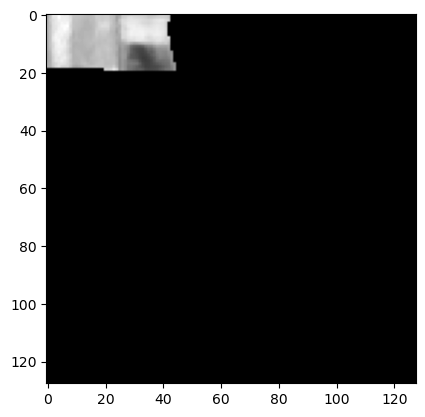

Img shape: (128, 128, 12)


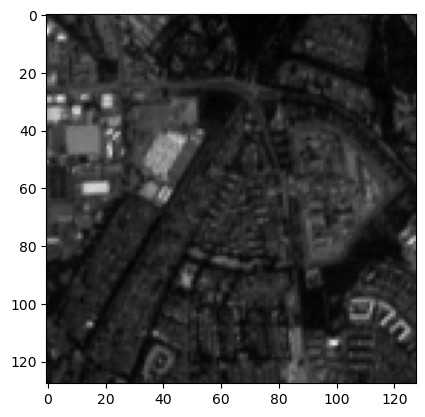

In [ ]:
# plotting random samples from DataLoader
def plot_random_samples_from_loader(dataloader, num_samples=3):
    indices = random.sample(range(len(dataloader.dataset)), num_samples)
    
    for idx in indices:
        img = dataloader.dataset[idx]
        img = img.permute(1, 2, 0).numpy() 
        print("Img shape:", img.shape)

        plot = plt.imshow(img[:, :, 3], cmap="gray")
        plt.show()


plot_random_samples_from_loader(test_loader)

### Defining the model

In [ ]:
# defining the metrics 
def calculate_iou(preds, masks, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * masks).sum(dim=(1, 2, 3))
    union = (preds + masks).sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

def calculate_accuracy(preds, masks, threshold=0.5):
    preds = (preds > threshold).float()
    correct = (preds == masks).float()
    accuracy = correct.sum() / correct.numel()
    return accuracy

In [244]:
class UNet(pl.LightningModule):
    def __init__(self, in_channels=12, out_channels=1, features=[64, 128, 256, 512], learning_rate=1e-4):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.decoder = nn.ModuleList()
        self.conv_final = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.learning_rate = learning_rate
        
        for feature in features:
            self.encoder.append(self._double_conv(in_channels, feature))
            in_channels = feature
        
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.decoder.append(self._double_conv(feature*2, feature))
        
        self.bottleneck = self._double_conv(features[-1], features[-1]*2)
        
    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        skip_connections = []
        
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx//2]
            
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])
            
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx+1](concat_skip)
        
        return self.conv_final(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), self.learning_rate)

    def training_step(self, batch, batch_idx):
        imgs, masks = batch
        preds = self(imgs)
        loss = F.binary_cross_entropy_with_logits(preds, masks)
        self.log("train_loss", loss)

        iou = calculate_iou(preds, masks)
        accuracy = calculate_accuracy(preds, masks)
        self.log("train_iou", iou, prog_bar=True)
        self.log("train_accuracy", accuracy, prog_bar=True)

        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        imgs, masks = batch
        preds = self(imgs)
        loss = F.binary_cross_entropy_with_logits(preds, masks)
        self.log("val_loss", loss)

        iou = calculate_iou(preds, masks)
        accuracy = calculate_accuracy(preds, masks)

        self.log("val_iou", iou, prog_bar=True)
        self.log("val_accuracy", accuracy, prog_bar=True)

        return {"val_loss": loss}

In [ ]:
# Loading saved model (don't forget to define the model first)

model = UNet()
model.load_state_dict(torch.load('path/model_name.pth'))
model.eval()
model.to('cuda')

### Getting the predictions

In [246]:
# getting the predictions

def get_predictions(model, dataloader, device="cuda"):
    model.eval()
    preds_list = []
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            images = batch
            images= images.to(device)

            preds = model(images)
            preds = torch.sigmoid(preds)  # Apply sigmoid if using binary classification
            preds = (preds > 0.5).float()  # Binarize predictions
            preds = preds.cpu().numpy() #.transpose((0, 1, 2, 3)) 
            preds_list.append(preds)

    preds_array = np.array(preds_list)
    preds_array = np.squeeze(preds_array, axis=1) # deleting 1 redundant array axis
    return preds_array

preds_ = get_predictions(model, test_loader)

In [ ]:
# Plotting predictions
preds_[0].shape
examples = preds_[4:7]

fig, axes = plt.subplots(3, figsize=(5, 3*5))
for i in range(0, len(examples)):
    example = examples[i]
    axes[i].imshow(example[0, :, :], cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# saving predictions to .npy file
np.save(f"path/{city_name}_preds.npy", preds_)

### Making inference results mosaic and rasterizing it
These steps are needed to make the georeferenced raster files from the predictions.

In [ ]:
# loading preds from .npy

# function used to rename the files
def extract_last_two_numbers(filename):
    parts = filename.split('_')
    second_last = int(parts[-2])
    last = int(parts[-1].split('.')[0])
    return (second_last, last)

In [ ]:
# first, saving tiles as separate files
# saving the change mask as .tif

path_save = f"path/rasterized_tiles_temp/{city_name}"

if not os.path.exists(path_save):
    os.mkdir(path_save)


profiles = []
# reading profiles for every original tile (defined in image_directories)
tile_list = os.listdir(image_directory)
tile_list = sorted(tile_list, key=extract_last_two_numbers)
for tile in tile_list:
    with rasterio.open(os.path.join(image_directory, tile)) as src:
        profiles.append(src.profile)

# writing the profiles to prediction tiles
counter = 0
for tile_, profile in zip(preds_, profiles):
    counter += 1
    profile.update({"count": 1})
    profile.update({"nodata": 2})
    # crs is used during mosaic writing to file
    crs = profile["crs"]
    path_save_tile = os.path.join(path_save, f"tile_{counter}.tif")
    with rasterio.open(path_save_tile, 'w', **profile) as dst:
        dst.write(tile_.astype(np.uint16))

In [ ]:
# saving tiles as a single .tif 

tiles_list = os.listdir(f"path/rasterized_tiles_temp/{city_name}")
tiles_list_paths = [os.path.join(f"path/rasterized_tiles_temp/{city_name}", i) for i in tiles_list]

tiles_src = []
for tile in tiles_list_paths:
    src = rasterio.open(tile)
    tiles_src.append(src)

mosaic, out_trans = merge(tiles_src)

# writing mosaic to .tif file
path_mosaics = f"path/mosaics/"

if not os.path.exists(path_mosaics):
    os.mkdir(path_mosaics)

out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff",
                    "height": mosaic.shape[1],
                    "width": mosaic.shape[2],
                    "transform": out_trans,
                    "crs": crs,
                    "compress": "lzw",
                    })

path_mosaic = os.path.join(path_mosaics, f"{city_name}_preds_mosaic.tif")

with rasterio.open(path_mosaic, "w", **out_meta) as dst:
    dst.write(mosaic)